In [1]:
############################################################################################################
################################## preprocess.py (by Ethan)#################################################
############################################################################################################

import pandas as pd
import matplotlib.pyplot as plt
import gensim

##One of them has a null value? okay.
def forcestring(x):
    if type(x) is str:
        return x
    return ""

## gensim removes stopwords, takes the stem of the rest, makes bag of words
def preproc(df):
    df['question1'] = df['question1'].apply(forcestring)
    df['question2'] = df['question2'].apply(forcestring)
    df['q1proc'] = df['question1'].apply(gensim.parsing.preprocessing.preprocess_string)
    df['q2proc'] = df['question2'].apply(gensim.parsing.preprocessing.preprocess_string)

In [2]:
############################################################################################################
################################ Random Forest Classifier     #################################################
############################################################################################################

from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import zero_one_loss
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn import tree



def RandomForestModel(dftrain, dftest, columnlist):
    model= RandomForestClassifier()

    X = dftrain[columnlist]
    y = dftrain['is_duplicate']

    model.fit(X, y)

    return model.predict(dftest[columnlist])


In [3]:
############################################################################################################
#################################  FeatureEngineering.py (by Ethan)  #######################################
############################################################################################################

## Making features
import pandas as pd
import gensim

## This makes the Jaccard similarity between the 2 preprocessed bag-of-words
## WARNING(!!!!!!): Luis works with (1-Jaccard) instead of (Jaccard) 

def Jac(x):
    if (len(x['q1proc']) > 0 and len(x['q2proc']) > 0):
        return 1-gensim.matutils.jaccard(x['q1proc'],x['q2proc']) 
    return 0

def JacFeat(df):
    df['jaccard'] = df.apply(Jac, axis=1)


## Make more features, put them in here
def makeFeatures(df):
    JacFeat(df)

In [4]:
### Standard String comparison implementation
def StrComparison(word1, word2):
    if word1 == word2:
        return 1
    return 0

In [5]:
############################################################################################################
#################################      FeatureCreation               #######################################
############################################################################################################

# We create 10 features as follows:
# Lets say that the question 1 has a bag of words Q1, and the question 2 has a bag of words Q2.
# At this point the bags are already sorted according to the histogram, for example
#     Q1 = ["step", "invest", "india"]
#     Q2 = ["step", "invest"]
#    ("india" is more comon than "invest" which is more common than "step")
# The following code just compares up to 5 elements of Q1 with each element of Q2 (and viceversa) 
#                                                                      using the jaccard distance

from __future__ import division

## Utility (there is a weird dependend of this function with the histogram, fix it !)
def Repetitions(word):  # Finds how many times is our word repeated on all the questions.
    for i in range(0, labels.size):
        if word == labels[i]:
            return values[i]   
    return 1


def FeatureCreation(dframe):
    
    dframe_size= dframe.shape[0]


    # The following array contains the bags of keywords obtained from the preprocessing
    KeyWords=dframe[['q1proc', 'q2proc']].as_matrix() 


    ## We arrange each bag of words in Keywords according to the histogram
    for i in range(0, dframe_size):
        KeyWords[i,0]= sorted(KeyWords[i,0], key=Repetitions)
        KeyWords[i,1]= sorted(KeyWords[i,1], key=Repetitions)

        
    features = np.zeros((dframe_size, 10))

    
    for j in range(0, dframe_size):
        Q1= KeyWords[j,0]
        Q2= KeyWords[j,1]
        for i in range(0, np.size(Q1)):
            if i<5:
                temp=[0]
                for word in Q2:
                    out = StrComparison(Q1[i],word)
                    temp.append(out)
                features[j,i] =  max(temp)/Repetitions(Q1[i])

                
        for i in range(0, np.size(Q2)):
            if i<5:
                temp=[0]
                for word in Q1:
                    temp.append(StrComparison(Q2[i],word))
                features[j,i+5] = max(temp)/Repetitions(Q2[i])
           
        
        
    dframe = dframe.assign(feat0 = features[:,0])
    dframe = dframe.assign(feat1 = features[:,1])
    dframe = dframe.assign(feat2 = features[:,2])
    dframe = dframe.assign(feat3 = features[:,3])
    dframe = dframe.assign(feat4 = features[:,4])
    dframe = dframe.assign(feat5 = features[:,5])
    dframe = dframe.assign(feat6 = features[:,6])
    dframe = dframe.assign(feat7 = features[:,7])
    dframe = dframe.assign(feat8 = features[:,8])
    dframe = dframe.assign(feat9 = features[:,9])  
    
    makeFeatures(dframe)
    
    return dframe

In [6]:
############################################################################################################
#################################   Histogram Generation (by Luis)   #######################################
############################################################################################################


import csv
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


def Histogram(word_list):   ## input :  word_list  is a list of words
                            ## returns: labels, values i.e. ["best", "like", ...], [195 times, 85 times, ...]
    counts = Counter(word_list)
    labels, values = zip(*counts.items())

    # sort your values in descending order
    indSort = np.argsort(values)[::-1]

    # rearrange your data
    labels = np.array(labels)[indSort]
    values = np.array(values)[indSort]

    indexes = np.arange(len(labels))


    # Plot a histogram with all the words
    fig = plt.figure(figsize=(15,10))
    plt.axis([0, 2000, 0, max(values)])
    plt.bar(indexes, values)
    plt.show()



    # Plot a histogram with the most common words
    fig = plt.figure(figsize=(15,10))
    plt.bar(indexes[:15], values[:15])
    plt.axis([0, 15, 0, max(values)])
    plt.xticks(indexes[:15], labels[:15])
    plt.show()
    
    return labels, values


In [7]:
###############  Examples of the Jaccard distance 
print "Jaccard_Distance(orange, orange)=" , gensim.matutils.jaccard(["orang"],["orange"])
print "Jaccard_Distance(defz, abcz)=" , gensim.matutils.jaccard("defz","abcz")
print "Jaccard_Distance(orange, germany)=" , gensim.matutils.jaccard("orange","germany")
print "Jaccard_Distance(science, mathematics)=" , gensim.matutils.jaccard("science","mathematics")
print "Jaccard_Distance(science, physics)=" , gensim.matutils.jaccard("science","physics")
print "Jaccard_Distance(orange, red)=" , gensim.matutils.jaccard("orange","red")
print "Jaccard_Distance(orange, run)=" , gensim.matutils.jaccard("orange","run")
print "Jaccard_Distance(orange, hope)=" , gensim.matutils.jaccard("orange","hope")
print "Jaccard_Distance(math, geometry)=" , gensim.matutils.jaccard("math","geometry")
print "Jaccard_Distance(science, trump)=" , gensim.matutils.jaccard("science","trump") 


Jaccard_Distance(orange, orange)= 1.0
Jaccard_Distance(defz, abcz)= 0.857142857143
Jaccard_Distance(orange, germany)= 0.375
Jaccard_Distance(science, mathematics)= 0.555555555556
Jaccard_Distance(science, physics)= 0.625
Jaccard_Distance(orange, red)= 0.714285714286
Jaccard_Distance(orange, run)= 0.714285714286
Jaccard_Distance(orange, hope)= 0.75
Jaccard_Distance(math, geometry)= 0.777777777778
Jaccard_Distance(science, trump)= 1.0


In [8]:
############################################################################################################
############################################################################################################
#######################                        MAIN                        #################################
############################################################################################################
############################################################################################################
import pandas as pd
import matplotlib.pyplot as plt
import gensim
import numpy as np
from sklearn.model_selection import train_test_split

In [9]:
################ Loading Data ##############################################################################
#dftrain = pd.DataFrame.from_csv('train_tiny.csv')
#dftest = pd.DataFrame.from_csv('test_tiny.csv')

dftrain = pd.DataFrame.from_csv('train.csv')
#dftest = pd.DataFrame.from_csv('test.csv')

dftrain, dfvalidation = train_test_split(dftrain, test_size = 0.2)

In [10]:
################ Data Preprocessing ######################################################################## 
#     Create two new features (q1proc, q2proc) containing the "key words" of each question ###### 
preproc(dftrain)
preproc(dfvalidation)
#preproc(dftest)

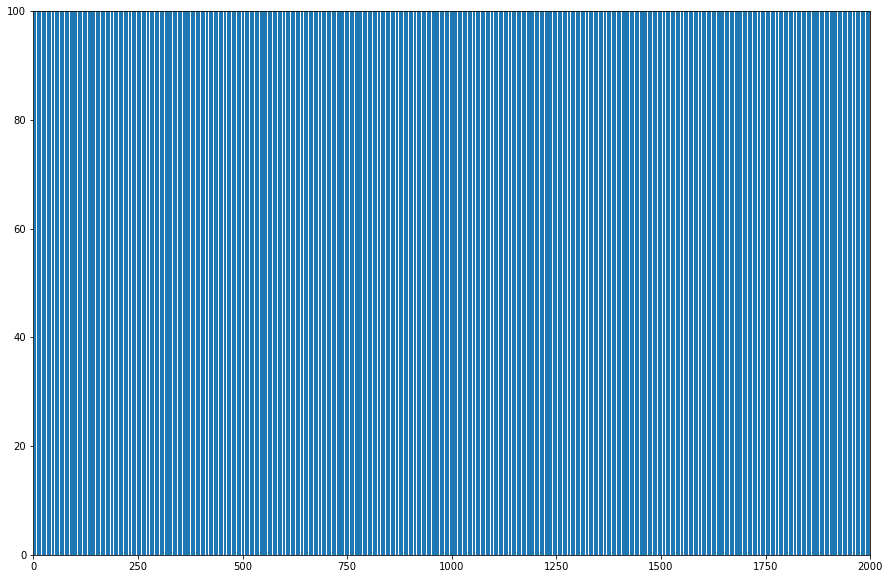

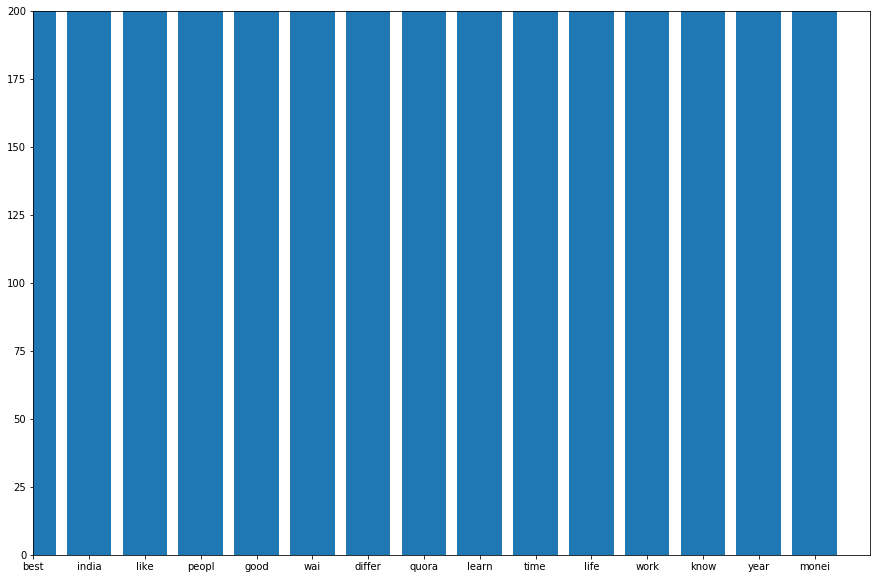

In [ ]:
############### Generate Histograms  ####################################
#     Generate histogram from the "key words" (from q1proc, q2proc)

Q= np.append(dftrain['q1proc'].as_matrix(), dftrain['q2proc'].as_matrix())
word_list=[]

for v in Q:
    for w in v:
        word_list.append(w)
        
labels, values = Histogram(word_list)

In [ ]:
###############  Feature Creation  ##############################################################################
dftrain= FeatureCreation(dftrain)
dfvalidation= FeatureCreation(dfvalidation)
#dftest = FeatureCreation(dftest)


In [ ]:
###############  Evaluating    Ethans Model  #####################################################################

Y_Predicted = RandomForestModel(dftrain, dfvalidation, ['jaccard'])
Y_True = dfvalidation['is_duplicate'].as_matrix()

## Confussion Matrix and error for Ethans approach
CM = confusion_matrix(Y_True, Y_Predicted)
Error = (float)(CM[0,1]+CM[1,0])/(CM[0,0]+CM[0,1]+CM[1,0]+CM[1,1])

print "Confussion Matrix for initial Ethans approach (only one feature)"
print CM
print "Percentaje of wrong answers = ", Error

In [ ]:
###############  Evaluating Ethan + 10 feature       ############################################################

features = ['jaccard', 'feat0', 'feat1', 'feat2', 'feat3', 'feat4', 'feat5', 'feat6', 'feat7', 'feat8', 'feat9']
Y_Predicted = RandomForestModel(dftrain, dfvalidation, features)
Y_True = dfvalidation['is_duplicate'].as_matrix()



## Confussion Matrix and error for 11 features
CM = confusion_matrix(Y_True, Y_Predicted)
Error = (float)(CM[0,1]+CM[1,0])/(CM[0,0]+CM[0,1]+CM[1,0]+CM[1,1])

print "Confussion Matrix for eleven features (only one feature)"
print CM
print "Percentaje of wrong answers = ", Error


In [ ]:
## Save your stuff to reload it in Section B
#dftrain.to_csv('preprocessed_train.csv', header = True)
#dftest.to_csv('preprocessed_test.csv', header = True)

## Save an answer for submission
#dfAnswer = dftest['is_duplicate']
#dfAnswer.to_csv('answer.csv', header = True)